# Implement
- CLiMF: Learning to Maximize Reciprocal Rank with Collaborative Less-is-More Filtering
http://baltrunas.info/papers/Shi12-climf.pdf

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from warp import WARPNaive, KosWARP
from bpr import BPR
from climf import CLiMF

In [4]:
dtype = np.float32

In [5]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [6]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

### learning rate decay

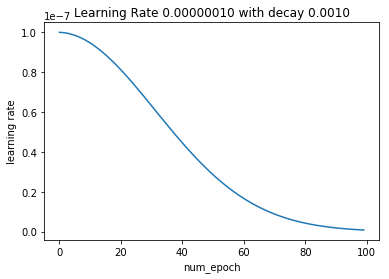

In [7]:
lrate = 1e-7
decay = 1e-3
lr_val = [lrate]
for i in range(1, 100):
    lr_val.append(lr_val[i-1] * (1. / (1. + (decay * i))))
plt.plot(np.arange(100), lr_val)
plt.xlabel("num_epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate %.8f with decay %.4f" % (lrate, decay))
plt.show()

## helpers

In [8]:
def plot_auc(title, auc_scores, num_epochs):
    epoch_x = np.arange(num_epochs)
    test_line, = plt.plot(epoch_x, auc_scores, label="auc test")
    plt.legend([test_line], ["test auc"])
    plt.xlabel("num_epoch")
    plt.ylabel("auc_score")
    plt.title(title)
    plt.show()

In [ ]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

/Users/timwee/anaconda3/lib/python3.5/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# CLiMF class

In [ ]:
durations = []
tst_climf_auc = []
tst_climf_prec5 = []
tst_climf_rr = []

climf_model = CLiMF(lr=1e-4, reg=0.001)
num_epochs = 50
for epoch in range(num_epochs):
    start = time.time()
    climf_model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(climf_model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(climf_model, test, train_interactions=train, k=5).mean()
    tst_rr = reciprocal_rank(climf_model, test, train_interactions=train).mean()
    tst_climf_auc.append(tst_auc)
    tst_climf_prec5.append(tst_prec5)
    tst_climf_rr.append(tst_rr)
    print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
          (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
Objective is:  -12743983.4794
iteration 0 took 11.3463, auc: 0.5005, p@5: 0.0085, rr: 0.0369
Objective is:  -12743982.4428
iteration 1 took 11.5240, auc: 0.5001, p@5: 0.0093, rr: 0.0399
Objective is:  -12743981.3751
iteration 2 took 11.6645, auc: 0.5000, p@5: 0.0095, rr: 0.0421
Objective is:  -12743980.2474
iteration 3 took 11.6805, auc: 0.5000, p@5: 0.0115, rr: 0.0486
Objective is:  -12743979.0258
iteration 4 took 11.6424, auc: 0.5005, p@5: 0.0131, rr: 0.0536
Objective is:  -12743977.6702
iteration 5 took 11.7106, auc: 0.5015, p@5: 0.0142, rr: 0.0564
Objective is:  -12743976.1315
iteration 6 took 11.7427, auc: 0.5030, p@5: 0.0161, rr: 0.0603
Objective is:  -12743974.3488
iteration 7 took 11.7145, auc: 0.5052, p@5: 0.0172, rr: 0.0643
Objective is:  -12743972.2465
iteration 8 took 11.6915, auc: 0.5081, p@5: 0.0193, rr: 0.0663
Objective is:  -12743969.7305
iteration 9 took 11.7358, auc: 0.5119, p@5: 0.0201, rr: 0.0714
Objective is:  -12743966.6848
iteration 10 too

In [ ]:
plot_auc("CLiMF AUC", tst_climf_auc, len(tst_climf_auc))